# Downloading data using netCDF Subset Service (NCSS)


This notebook shows ways to list all the data collection, sub-collections, datasets and files from NCI's THREDDS service portal. 

* NetCDF Subset Service (NCSS)
* Use Siphon to make an NCSS request
* Plot requested data using CartoPy
* NCSS point request 
* Construct NCSS query through the THREDDS NCSS service end point
---


- Authors: NCI Virtual Research Environment Team
- Keywords: THREDDS, Siphon, NCSS, subset
- Create Date: 2020-Jul

---


### THREDDS Netcdf Subset Service (NCSS)

The Netcdf Subset Service (NCSS) is one of the data service endpoints available on many of NCI's hosted data collections. NCSS is currently available on NCI's gridded datasets and allows users to request spatial and temporal queries using longitude and latitude values directly.

 The cell below extracts the catalog information.

In [17]:
from siphon.catalog import TDSCatalog

cat = TDSCatalog("http://dapds00.nci.org.au/thredds/catalog/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/3hr/pr/gn/latest/catalog.xml")

ncss=cat.datasets[-1].subset()
cat.datasets[-1]


pr_3hr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_201001010130-201412312230.nc

In [18]:
ncss.variables

{'pr'}

we can build a query to ask for the data we want from the THREDDS server.

In [19]:
from datetime import date, timedelta

# Create a new NCSS query
query = ncss.query()

# Request data in netCDF format
query.accept('netcdf')

# Ask for our variable
query.variables('pr')

# Set the time range of data we want
start = date.fromisoformat('2013-12-31')
query.time_range(start, start + timedelta(days=365))

# Set the spatial limits - Australia
query.lonlat_box(west=110, east=160, north=-10, south=-50)

# get the data!
data = ncss.get_data(query)

Store the netCDF data:

In [23]:
from xarray.backends import NetCDF4DataStore
import xarray as xr
ds = xr.open_dataset(NetCDF4DataStore(data))
ds.to_netcdf('NCSS_reqest_data.nc')

### Visualisa the data

In [27]:
var = ds.pr
var

<xarray.DataArray 'pr' (time: 2920, lat: 33, lon: 27)>
[2601720 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2013-12-31T01:30:00 ... 2014-12-30T22:30:00
  * lat      (lat) float64 -50.0 -48.75 -47.5 -46.25 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 153.8 155.6 157.5 159.4
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T03:29:51Z altered by CMOR: replaced missing va...
    _ChunkSizes:    [  1 145 192]

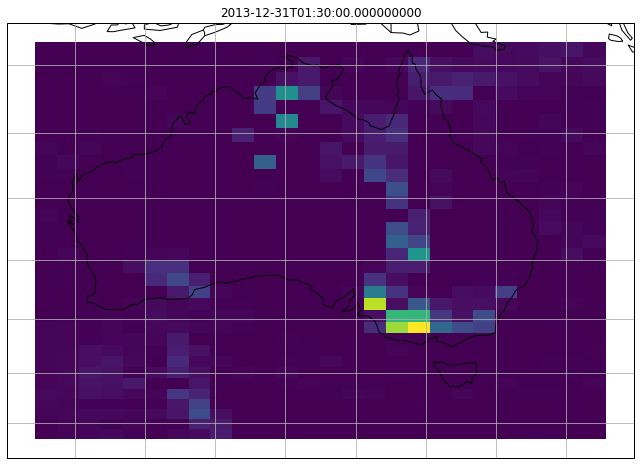

In [38]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

latitude = var.lat
longitude = var.lon
time_index =0
# Plot using CartoPy and Matplotlib
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertCylindrical())
data_projection = ccrs.PlateCarree()

ax.pcolormesh(longitude, latitude, var[time_index].squeeze(),
              transform=data_projection, zorder=0)
ax.set_title(var.time[time_index].values)

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

### NCSS Point request

We can also request data for a specfic lon/lat point, across vertical coordinates or times.

In [49]:
point_query = ncss.query()
startd = date.fromisoformat('2013-12-31')
point_query.time_range(startd, startd + timedelta(days=365))
point_query.accept('netcdf')
point_query.variables('pr')
point_query.lonlat_point(149.13, -35.28)

# get the data! Unfortunately, xarray does not quite like what comes out of thredds
point_data = ncss.get_data(point_query)
ds = xr.open_dataset(NetCDF4DataStore(point_data))
ds.time


<xarray.DataArray 'time' (obs: 2920)>
array(['2013-01-01T01:30:00.000000000', '2013-01-01T04:30:00.000000000',
       '2013-01-01T07:30:00.000000000', ..., '2013-12-31T16:30:00.000000000',
       '2013-12-31T19:30:00.000000000', '2013-12-31T22:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time     (obs) datetime64[ns] 2013-01-01T01:30:00 ... 2013-12-31T22:30:00
Dimensions without coordinates: obs
Attributes:
    standard_name:  time
    long_name:      time

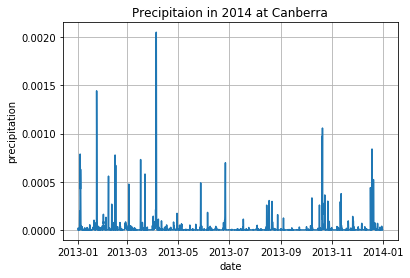

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = ds.time
p = ds.pr

fig, ax = plt.subplots()
ax.plot(t, p)

ax.set(xlabel='date', ylabel='precipitation',
       title='Precipitaion in 2014 at Canberra')
ax.grid()

plt.show()

### NCSS request through the THREDDS weblink

Begin by navigating to the THREDDS catalog page for the selected data file (http://dapds00.nci.org.au/thredds/catalog/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/rcp85/mon/atmos/Amon/r1i1p1/latest/tas/catalog.html?dataset=rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/rcp85/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc):

![](images/ncss1_cmip5.png)

Next, decide whether you want to extract a spatial subset (left/green arrow), defined by a bounding box, or a single point in space (right/red arrow), defined by a single latitude and longitude:


![](images/ncss2_cmip5.png)

Then proceed by selecting the desired variables, spatial (or lat/lon point) and temporal extents. As selections are made, the NCSS Request URL (near bottom of the page) will update with these parameters. 


![](images/ncss3_cmip5.png)



Click 'Submit' and the request file should begin to download. Alternatively, the NCSS URL can be copied/pasted into a new web browser or used in workflows along with `wget` or `curl` commands. 


**Examples of different NCSS Request URLs:**
> http://dapds00.nci.org.au/thredds/ncss/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/rcp85/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc?latitude=&longitude=&time_start=2006-01-16T12%3A00%3A00Z&time_end=2100-12-16T12%3A00%3A00Z&accept=netcdf

> http://dapds00.nci.org.au/thredds/ncss/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/rcp85/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc?latitude=&longitude=&time_start=2006-01-16T12%3A00%3A00Z&time_end=2100-12-16T12%3A00%3A00Z&accept=csv



### Summery

We demonstrate how to use Siphon to query the subset of a dataset and how to use THREDDS NCSS service to subset data. 